<a href="https://colab.research.google.com/github/AshmithaMB/VADER_Sentiment_Analysis/blob/main/financial_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Project Overview :***

*The aim of this project is to develop a machine learning model that can predict the sentiment (positive, negative, or neutral) of financial news based on the text content of their descriptions and headlines.*
 
> *By analyzing and classifying the sentiments expressed in financial news, this model can assist investors and financial professionals in making informed decisions and understanding market trends.*

***Problem Statement :***

*The financial market is highly influenced by news and sentiment. The ability to accurately predict the sentiment of financial news can provide valuable insights for investors, traders, and financial institutions.* 

> *This project aims to address the challenge of sentiment analysis in the financial domain by developing a predictive model that can classify news articles into positive, negative, or neutral sentiments based on their descriptions and headlines.*

***About Dataset***


***Context***
> *Scraped from CNBC, the Guardian, and Reuters official websites, the headlines in these datasets reflects the overview of the U.S. economy and stock market every day for the past year to 2 years.*

***Content***

*The dataset contains 3 csv files*


* ***CNBC Headlines***   *(3080, 3)*
* *Columns  -   Time, Headlines and Description*
>   *Data scraped from CNBC contains the headlines, last updated date, and the preview text of articles from the end of December 2017 to July 19th, 2020.*

* ***Guardian Headlines***   *(17800, 2)*
* *Columns  -   Time, Headlines*
> *Data scraped from the Guardian Business contains the headlines and last updated date of articles from the end of December 2017 to July 19th, 2020 since the Guardian Business does not offer preview text.*


* ***Reuters Headlines***   *(32770, 3)*
* *Columns  -   Time, Headlines and Description*
> *Data scraped from Reuters contains the headlines, last updated date, and the preview text of articles from the end of March 2018 to July 19th, 2020.*

##### *Importing Libraries*

In [1]:
import pandas as pd
import numpy as np
import re 
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 4.3 MB/s eta 0:00:00


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### *Understanding CNBC Headlines*

In [5]:
cnbc_headlines = pd.read_csv("/content/cnbc_headlines.csv")

In [6]:
cnbc_headlines.head()

,Headlines,Time,Description
0,Jim Cramer: A better way to invest in the Covi...,"7:51 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer recommended buying..."
1,Cramer's lightning round: I would own Teradyne,"7:33 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer rings the lightnin..."
2,NaN,NaN,NaN
3,"Cramer's week ahead: Big week for earnings, ev...","7:25 PM ET Fri, 17 July 2020","""We'll pay more for the earnings of the non-Co..."
4,IQ Capital CEO Keith Bliss says tech and healt...,"4:24 PM ET Fri, 17 July 2020","Keith Bliss, IQ Capital CEO, joins ""Closing Be..."


In [7]:
cnbc_headlines.shape

(3080, 3)

In [8]:
cnbc_headlines.columns

Index(['Headlines', 'Time', 'Description'], dtype='object')

In [9]:
cnbc_headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    2800 non-null   object
 1   Time         2800 non-null   object
 2   Description  2800 non-null   object
dtypes: object(3)
memory usage: 72.3+ KB


*Addressing the Missing Values*

In [10]:
cnbc_headlines.isnull().sum()

Headlines      280
Time           280
Description    280
dtype: int64

In [11]:
cnbc_headlines = cnbc_headlines.dropna()

In [12]:
cnbc_headlines = cnbc_headlines.drop_duplicates(subset = ['Headlines', 'Description'], keep = 'first')
cnbc_headlines.reset_index(drop = True, inplace = True)
cnbc_headlines

,Headlines,Time,Description
0,Jim Cramer: A better way to invest in the Covi...,"7:51 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer recommended buying..."
1,Cramer's lightning round: I would own Teradyne,"7:33 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer rings the lightnin..."
2,"Cramer's week ahead: Big week for earnings, ev...","7:25 PM ET Fri, 17 July 2020","""We'll pay more for the earnings of the non-Co..."
3,IQ Capital CEO Keith Bliss says tech and healt...,"4:24 PM ET Fri, 17 July 2020","Keith Bliss, IQ Capital CEO, joins ""Closing Be..."
4,Wall Street delivered the 'kind of pullback I'...,"7:36 PM ET Thu, 16 July 2020","""Look for the stocks of high-quality companies..."
...,...,...,...
2785,Markets lack Christmas cheer,"10:15 AM ET Tue, 26 Dec 2017","According to Kensho, here's how markets have f..."
2786,Cramer Remix: The biggest mistake you can make...,"11:12 AM ET Thu, 20 Sept 2018",Jim Cramer revealed his top rule when it comes...
2787,Cramer says owning too many stocks and too lit...,"7:07 PM ET Fri, 22 Dec 2017",Jim Cramer broke down why owning fewer stocks ...
2788,Cramer: I helped investors through the 2010 fl...,"7:07 PM ET Fri, 22 Dec 2017","Jim Cramer built on his ""nobody ever made a di..."


In [13]:
cnbc_headlines.shape

(2790, 3)

### *Understanding Gaurdian Headlines*

In [14]:
gaurdian_headlines = pd.read_csv("/content/guardian_headlines.csv")

In [15]:
gaurdian_headlines.head()

,Time,Headlines
0,18-Jul-20,Johnson is asking Santa for a Christmas recovery
1,18-Jul-20,‘I now fear the worst’: four grim tales of wor...
2,18-Jul-20,Five key areas Sunak must tackle to serve up e...
3,18-Jul-20,Covid-19 leaves firms ‘fatally ill-prepared’ f...
4,18-Jul-20,The Week in Patriarchy \n\n\n Bacardi's 'lad...


In [16]:
gaurdian_headlines.shape

(17800, 2)

In [17]:
gaurdian_headlines.columns

Index(['Time', 'Headlines'], dtype='object')

In [18]:
gaurdian_headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17800 entries, 0 to 17799
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       17800 non-null  object
 1   Headlines  17800 non-null  object
dtypes: object(2)
memory usage: 278.2+ KB


In [19]:
gaurdian_headlines.isnull().sum()

Time         0
Headlines    0
dtype: int64

###### *Addressing Duplicate Entries*

In [20]:
gaurdian_headlines = gaurdian_headlines.drop_duplicates(subset = ['Headlines'], keep = 'first')
gaurdian_headlines.reset_index(drop = True, inplace = True)
gaurdian_headlines

,Time,Headlines
0,18-Jul-20,Johnson is asking Santa for a Christmas recovery
1,18-Jul-20,‘I now fear the worst’: four grim tales of wor...
2,18-Jul-20,Five key areas Sunak must tackle to serve up e...
3,18-Jul-20,Covid-19 leaves firms ‘fatally ill-prepared’ f...
4,18-Jul-20,The Week in Patriarchy \n\n\n Bacardi's 'lad...
...,...,...
17790,17-Dec-17,How investing in solar energy can create a bri...
17791,17-Dec-17,Poundland suppliers hit by insurance downgrade
17792,17-Dec-17,Cryptocurrencies: City watchdog to investigate...
17793,17-Dec-17,Unilever sells household name spreads to KKR f...


In [21]:
gaurdian_headlines.shape

(17795, 2)

### *Understanding Reuters Headlines*

In [22]:
reuters_headlines = pd.read_csv("/content/reuters_headlines.csv")
reuters_headlines.head()

,Headlines,Time,Description
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...


In [23]:
reuters_headlines.shape

(32770, 3)

In [24]:
reuters_headlines.columns

Index(['Headlines', 'Time', 'Description'], dtype='object')

In [25]:
reuters_headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32770 entries, 0 to 32769
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    32770 non-null  object
 1   Time         32770 non-null  object
 2   Description  32770 non-null  object
dtypes: object(3)
memory usage: 768.2+ KB


In [26]:
reuters_headlines.isnull().sum()

Headlines      0
Time           0
Description    0
dtype: int64

###### *Addressing Duplicate Entries*

In [27]:
reuters_headlines = reuters_headlines.drop_duplicates(subset = ['Headlines', 'Description'], keep = 'first')
reuters_headlines.reset_index(drop = True, inplace = True)
reuters_headlines

,Headlines,Time,Description
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...
...,...,...,...
32668,Malaysia says never hired British data firm at...,Mar 20 2018,The Malaysian government and the ruling party ...
32669,Prosecutors search Volkswagen headquarters in ...,Mar 20 2018,German prosecutors said on Tuesday they had se...
32670,McDonald's sets greenhouse gas reduction targets,Mar 20 2018,McDonald's Corp on Tuesday announced an approv...
32671,Pratt & Whitney to deliver spare A320neo engin...,Mar 20 2018,Pratt & Whitney will soon begin deliveries of ...


In [28]:
reuters_headlines.shape

(32673, 3)

***Preprocessing Text***

> Lower-casing

> Punctuation Removal

> Stopwards Removal

> Tokenization

> Lemmatizing

In [29]:
def preprocess(text):
    if pd.isnull(text):
        return ''
    
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stopword = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    cleaned_text = [ word for word in tokens if word not in stopword ]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(w, pos = 'a') for w in cleaned_text]
    return ' '.join(lemmatized_tokens)
  

***Sentiment Analysis***

In [30]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [31]:
analyzer = SentimentIntensityAnalyzer()

In [32]:
def analyse_score(score):
  if score < 0.0:
    return 'Negative'
  elif score == 0.0:
    return 'Neutral'
  else :
    return 'Positive'

#### *Analyzing the Descriptions and Headlines*

In [33]:
concatenated_df = pd.concat([reuters_headlines, gaurdian_headlines, cnbc_headlines], axis=0)
concatenated_df.reset_index(drop=True, inplace=True)
concatenated_df

,Headlines,Time,Description
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...
...,...,...,...
53253,Markets lack Christmas cheer,"10:15 AM ET Tue, 26 Dec 2017","According to Kensho, here's how markets have f..."
53254,Cramer Remix: The biggest mistake you can make...,"11:12 AM ET Thu, 20 Sept 2018",Jim Cramer revealed his top rule when it comes...
53255,Cramer says owning too many stocks and too lit...,"7:07 PM ET Fri, 22 Dec 2017",Jim Cramer broke down why owning fewer stocks ...
53256,Cramer: I helped investors through the 2010 fl...,"7:07 PM ET Fri, 22 Dec 2017","Jim Cramer built on his ""nobody ever made a di..."


In [34]:
text = concatenated_df['Headlines'] + ' ' + concatenated_df['Description']
time = concatenated_df['Time']
df = pd.DataFrame({'Text': text, 'Time': time})
df

,Text,Time
0,TikTok considers London and other locations fo...,Jul 18 2020
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020
3,Twitter says attackers downloaded data from up...,Jul 18 2020
4,U.S. Republicans seek liability protections as...,Jul 17 2020
...,...,...
53253,Markets lack Christmas cheer According to Kens...,"10:15 AM ET Tue, 26 Dec 2017"
53254,Cramer Remix: The biggest mistake you can make...,"11:12 AM ET Thu, 20 Sept 2018"
53255,Cramer says owning too many stocks and too lit...,"7:07 PM ET Fri, 22 Dec 2017"
53256,Cramer: I helped investors through the 2010 fl...,"7:07 PM ET Fri, 22 Dec 2017"


In [35]:
df['Text'] = df['Text'].apply(preprocess)

In [36]:
text_score = []

for value in df.Text.values:
  text_score.append(analyzer.polarity_scores(value)['compound'])

df['Text Score'] = text_score
df.head()

,Text,Time,Text Score
0,tiktok considers london locations headquarters...,Jul 18 2020,0.0258
1,disney cuts ad spending facebook amid growing ...,Jul 18 2020,-0.8934
2,trail missing wirecard executive leads belarus...,Jul 18 2020,-0.6486
3,twitter says attackers downloaded data eight n...,Jul 18 2020,-0.5719
4,us republicans seek liability protections coro...,Jul 17 2020,-0.7269


In [37]:
df['Text Score'] = df['Text Score'].apply(analyse_score)
df

,Text,Time,Text Score
0,tiktok considers london locations headquarters...,Jul 18 2020,Positive
1,disney cuts ad spending facebook amid growing ...,Jul 18 2020,Negative
2,trail missing wirecard executive leads belarus...,Jul 18 2020,Negative
3,twitter says attackers downloaded data eight n...,Jul 18 2020,Negative
4,us republicans seek liability protections coro...,Jul 17 2020,Negative
...,...,...,...
53253,markets lack christmas cheer according kensho ...,"10:15 AM ET Tue, 26 Dec 2017",Positive
53254,cramer remix big mistake make taxes stock mark...,"11:12 AM ET Thu, 20 Sept 2018",Positive
53255,cramer says owning many stocks little cash set...,"7:07 PM ET Fri, 22 Dec 2017",Negative
53256,cramer helped investors 2010 flash crash follo...,"7:07 PM ET Fri, 22 Dec 2017",Negative


In [38]:
score_counts = df['Text Score'].value_counts()
score_counts

Neutral     21130
Positive    17761
Negative    14367
Name: Text Score, dtype: int64

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

* *The analysis below was conducted by combining the information from both the headlines and descriptions, and analyzing the entire text data.* 

* *The resulting graph provides insights into the distribution of sentiments within the dataset, highlighting the prevalence of neutral sentiments, followed by negative and positive sentiments.*

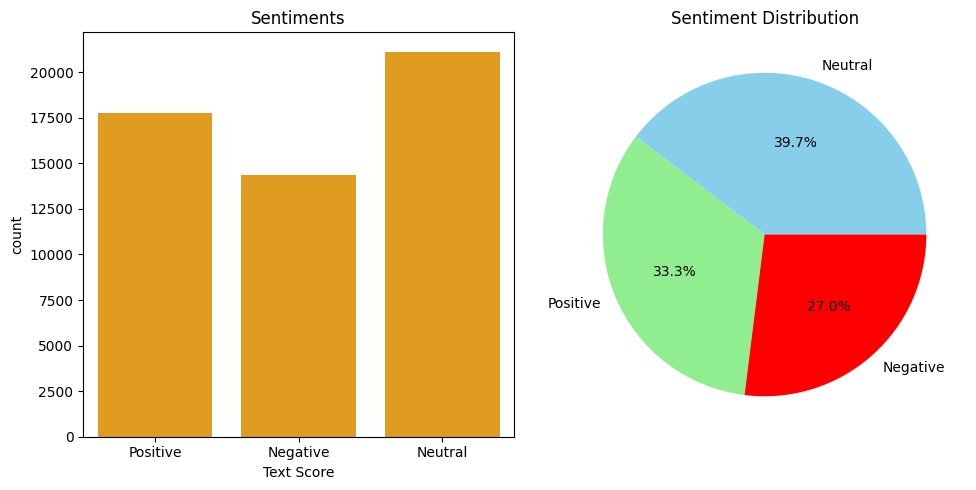

In [40]:
countplot_colors = ['orange']

plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.countplot(x='Text Score', data=df, color=countplot_colors[0])
plt.title('Sentiments')

piechart_colors = [ 'skyblue', 'lightgreen',  'red']
plt.subplot(122)
plt.pie(score_counts, labels=score_counts.index, colors=piechart_colors, autopct='%1.1f%%')
plt.title('Sentiment Distribution')

plt.tight_layout();

* *Based on the graph above, it can be observed that approximately **22,000 sentiments** in the financial news headlines and descriptions were classified as **neutral**, accounting for **39.7% **of the total dataset.* 
* *Additionally, around **13,500 sentiments** were classified as **negative**, representing **27%** of the total, while approximately **17,500 sentiments** were classified as **positive**, accounting for **33.3%** of the total dataset.*



#### *Analyzing the lengths*

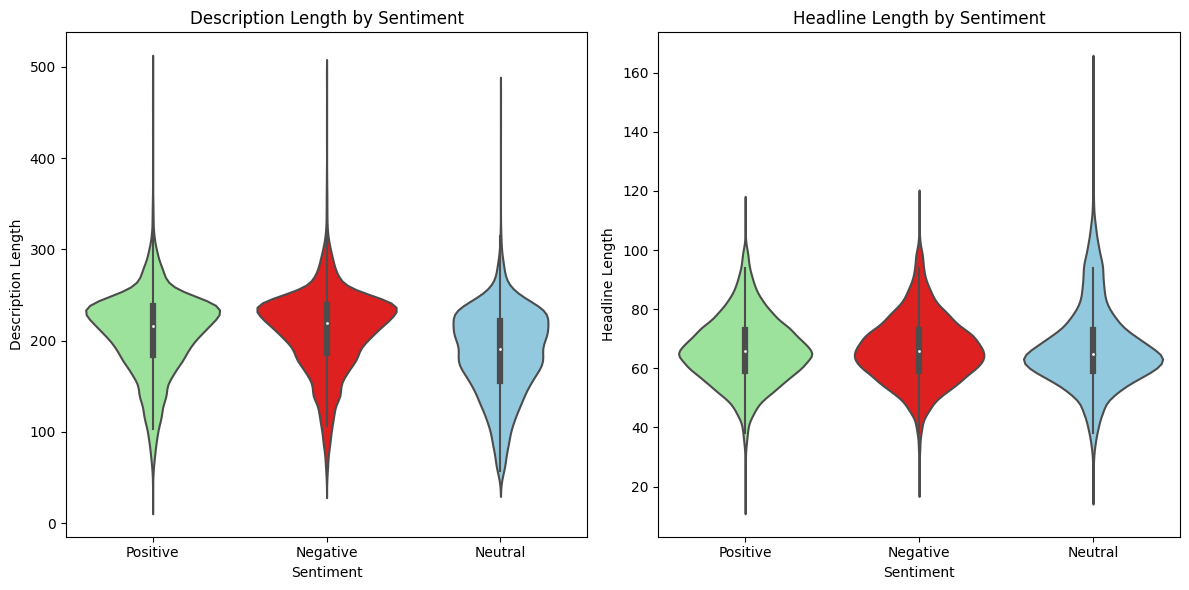

In [41]:
headline_lengths = concatenated_df['Headlines'].str.len()
description_lengths = concatenated_df['Description'].str.len()
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.violinplot(x='Text Score', y=description_lengths, data=df, ax=axes[0], palette=['lightgreen', 'red', 'skyblue'])
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Description Length')
axes[0].set_title('Description Length by Sentiment')

sns.violinplot(x='Text Score', y=headline_lengths, data=df, ax=axes[1], palette=['lightgreen', 'red', 'skyblue'])
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Headline Length')
axes[1].set_title('Headline Length by Sentiment')

plt.tight_layout()

***Description Length:***

* ***`Positive Sentiments:`*** 
> *The description length for positive statements mostly falls between 100 and 300 words, with the mean centered around 210 words. There are very few descriptions that have a length of 500 words.*

* ***`Negative Sentiments:`***
> *Similar to positive sentiments, the description length for negative statements is also primarily between 100 and 300 words, with the mean centered around 210 words. The number of descriptions with a length of 500 words is negligible.*

* ***`Neutral Sentiments:`***
> *For neutral sentiments, the description length ranges from 50 to 280 words, with the mean around 85 words. There are no descriptions with a length of 500 words.*


***Headline Length:***

* ***`Positive Sentiments: `*** 
> *The headline length for positive statements ranges from a minimum of 10 words to a maximum of 160 words. However, the majority of headlines fall within the range of 30 to 110 words, with a mean length around 62 words.*
* ***`Negative Sentiments:`*** 
> Similar to positive sentiments, the headline length for negative statements is almost the same, ranging from 40 to 100 words, with a mean around 62 words.

* ***`Neutral Sentiments:`*** 
> *For neutral sentiments, the headline length varies from a minimum of 10 words to a maximum of 160 words. The majority of headlines are around 30 to 110 words in length, with a mean of approximately 62 words.*

#### *Modelling on Headlines + Description* 

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], 
                                                    df['Text Score'], 
                                                    test_size = 0.1, 
                                                    random_state = 222 )

*LINEAR SUPPORT VECTOR MACHINE*


In [43]:
%%time
pipeline = Pipeline([
    ('Tfidf Vectorizer', TfidfVectorizer()),
    ('ML Model', LinearSVC())])

model_LinearSVC1 = pipeline.fit(X_train, y_train)
predictions = model_LinearSVC1.predict(X_test)

print('ML Model - Linear SVC\n')

accuracy_LinearSVC1 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_LinearSVC1 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))

ML Model - Linear SVC

Accuracy Score: 89.3%

Confusion Matrix
[[1239   39  164]
 [  62 1913  117]
 [ 140   48 1604]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86      1442
     Neutral       0.96      0.91      0.93      2092
    Positive       0.85      0.90      0.87      1792

    accuracy                           0.89      5326
   macro avg       0.89      0.89      0.89      5326
weighted avg       0.89      0.89      0.89      5326

CPU times: user 5.06 s, sys: 52.5 ms, total: 5.11 s
Wall time: 9.45 s


*LOGISTIC REGRESSION*


In [44]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', LogisticRegression())])

model_LogR1 = pipeline.fit(X_train, y_train)
predictions = model_LogR1.predict(X_test)

accuracy_LogR1 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_LogR1 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))

Accuracy Score: 86.88%

Confusion Matrix
[[1182   47  213]
 [  72 1877  143]
 [ 160   64 1568]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.84      0.82      0.83      1442
     Neutral       0.94      0.90      0.92      2092
    Positive       0.81      0.88      0.84      1792

    accuracy                           0.87      5326
   macro avg       0.87      0.86      0.86      5326
weighted avg       0.87      0.87      0.87      5326

CPU times: user 8.26 s, sys: 8.61 s, total: 16.9 s
Wall time: 11.6 s


*BERNOULLI NAIVE BAYES*


In [45]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', BernoulliNB())
])

model_BNB1 = pipeline.fit(X_train, y_train)
predictions = model_BNB1.predict(X_test)
accuracy_BNB1 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_BNB1 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))


Accuracy Score: 81.36%

Confusion Matrix
[[1074    4  364]
 [  88 1776  228]
 [ 305    4 1483]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.73      0.74      0.74      1442
     Neutral       1.00      0.85      0.92      2092
    Positive       0.71      0.83      0.77      1792

    accuracy                           0.81      5326
   macro avg       0.81      0.81      0.81      5326
weighted avg       0.83      0.81      0.82      5326

CPU times: user 1.48 s, sys: 12.9 ms, total: 1.49 s
Wall time: 1.5 s


*MULTINOMIAL NAIVE BAYES*


In [46]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', MultinomialNB())])

model_MNB1 = pipeline.fit(X_train, y_train)
predictions = model_MNB1.predict(X_test)
accuracy_MNB1 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_MNB1 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))



Accuracy Score: 79.74%

Confusion Matrix
[[ 870   11  561]
 [  61 1769  262]
 [ 175    9 1608]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.79      0.60      0.68      1442
     Neutral       0.99      0.85      0.91      2092
    Positive       0.66      0.90      0.76      1792

    accuracy                           0.80      5326
   macro avg       0.81      0.78      0.79      5326
weighted avg       0.82      0.80      0.80      5326

CPU times: user 1.55 s, sys: 6.6 ms, total: 1.55 s
Wall time: 1.56 s


*CATBOOST CLASSIFICATION MODEL*

In [47]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', CatBoostClassifier(iterations=10, random_state=33, verbose=False))
])

model_CB1 = pipeline.fit(X_train, y_train)
predictions = model_CB1.predict(X_test)
print('ML Model - CatBoost\n')

accuracy_CB1 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_CB1 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))

ML Model - CatBoost

Accuracy Score: 69.92%

Confusion Matrix
[[ 584  273  585]
 [  40 1839  213]
 [ 229  262 1301]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.68      0.40      0.51      1442
     Neutral       0.77      0.88      0.82      2092
    Positive       0.62      0.73      0.67      1792

    accuracy                           0.70      5326
   macro avg       0.69      0.67      0.67      5326
weighted avg       0.70      0.70      0.69      5326

CPU times: user 44.4 s, sys: 2.18 s, total: 46.6 s
Wall time: 27.7 s


In [48]:
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [49]:
def model_comparision(Models, Names, X_train, y_train, X_test, y_test):

  for (Model , Name) in zip(Models, Names):
    print(Name)

    y_pred = Model.predict(X_test)
    results = classification_report(y_test, y_pred)

    print('Classification Report \n', results)

In [50]:
models = [model_LinearSVC1,
          model_LogR1, 
          model_MNB1,
          model_BNB1,
          model_CB1]

names = ['LinearSVC', 
         'Logistic Regression', 
         'Multinomial Naive Bayes',
         'Bernoulli\'s Naive Bayes',
         'CatBoostClassifier']

model_comparision(models, names, X_train, y_train, X_test, y_test)

LinearSVC
Classification Report 
               precision    recall  f1-score   support

    Negative       0.86      0.86      0.86      1442
     Neutral       0.96      0.91      0.93      2092
    Positive       0.85      0.90      0.87      1792

    accuracy                           0.89      5326
   macro avg       0.89      0.89      0.89      5326
weighted avg       0.89      0.89      0.89      5326

Logistic Regression
Classification Report 
               precision    recall  f1-score   support

    Negative       0.84      0.82      0.83      1442
     Neutral       0.94      0.90      0.92      2092
    Positive       0.81      0.88      0.84      1792

    accuracy                           0.87      5326
   macro avg       0.87      0.86      0.86      5326
weighted avg       0.87      0.87      0.87      5326

Multinomial Naive Bayes
Classification Report 
               precision    recall  f1-score   support

    Negative       0.79      0.60      0.68      1442
   

#### *Testing with the test data*

In [51]:
y_predicted = model_LinearSVC1.predict(X_test)
y_predicted

array(['Positive', 'Neutral', 'Positive', ..., 'Neutral', 'Positive',
       'Negative'], dtype=object)

In [52]:
predictions = pd.DataFrame(y_predicted)
predictions

,0
0,Positive
1,Neutral
2,Positive
3,Neutral
4,Positive
...,...
5321,Negative
5322,Negative
5323,Neutral
5324,Positive


> *Based on the experiments I conducted on the combined dataset of headlines and descriptions, it can be concluded that the ***Linear SVC*** algorithm performed the best in terms of sentiment prediction accuracy, achieving an accuracy score of **89.3%**.*

*For the next phase of my analysis, I will evaluate the models individually on the headlines and descriptions separately. This approach will allow me to examine the predictive power of each algorithm specifically on these two text features and gain further insights into their performance in capturing sentiment patterns within **Headlines and Descriptions**.*

#### *Headlines*

In [53]:
df_headlines = concatenated_df.drop(columns = ['Description'], axis = 1)
df_headlines.head()

,Headlines,Time
0,TikTok considers London and other locations fo...,Jul 18 2020
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020
3,Twitter says attackers downloaded data from up...,Jul 18 2020
4,U.S. Republicans seek liability protections as...,Jul 17 2020


In [54]:
df_headlines['Headline Score'] = df_headlines['Headlines'].apply(lambda x: analyse_score(analyzer.polarity_scores(x)['compound']))

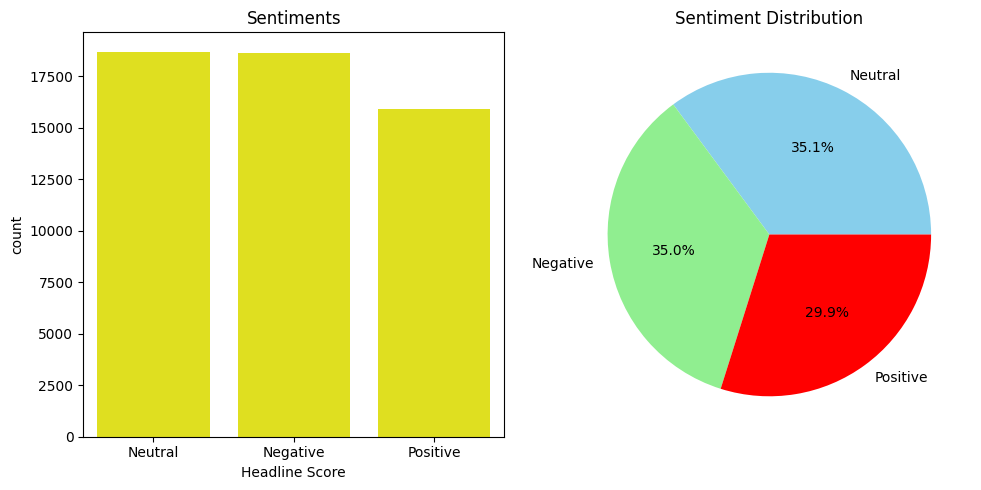

In [55]:
score_counts = df_headlines['Headline Score'].value_counts()

plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.countplot(x='Headline Score', data=df_headlines, color = 'yellow')
plt.title('Sentiments')

colors = ['skyblue',  'red', 'lightgreen']
plt.subplot(122)
plt.pie(score_counts, labels=score_counts.index, colors=piechart_colors, autopct='%1.1f%%')
plt.title('Sentiment Distribution')

plt.tight_layout();

#### *Analysis focused solely on predicting sentiments based on Headlines*


* *The majority of sentiments were either **negative or neutral**, totaling approximately **18,500** instances. These negative and neutral sentiments accounted for **35%** and **35.1%** of the total, respectively.* 
* *On the other hand, **positive sentiments** constituted around **15,100** instances, which corresponded to **29.9%** of the total sentiments captured in the headlines*

#### *Modeling on Headlines*

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df_headlines['Headlines'], 
                                                    df_headlines['Headline Score'], 
                                                    test_size = 0.1, 
                                                    random_state = 222 )

*LINEAR SUPPORT VECTOR MACHINE*

In [57]:
%%time
pipeline = Pipeline([
    ('Tfidf Vectorizer', TfidfVectorizer()),
    ('ML Model', LinearSVC())])

model_LinearSVC11 = pipeline.fit(X_train, y_train)
predictions = model_LinearSVC11.predict(X_test)

print('ML Model - Linear SVC\n')

accuracy_LinearSVC11 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_LinearSVC11 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))

ML Model - Linear SVC

Accuracy Score: 90.87%

Confusion Matrix
[[1682   97  106]
 [  51 1779   38]
 [ 113   81 1379]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      1885
     Neutral       0.91      0.95      0.93      1868
    Positive       0.91      0.88      0.89      1573

    accuracy                           0.91      5326
   macro avg       0.91      0.91      0.91      5326
weighted avg       0.91      0.91      0.91      5326

CPU times: user 1.75 s, sys: 4.64 ms, total: 1.75 s
Wall time: 1.76 s


*LOGISTIC REGRESSION*

In [58]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', LogisticRegression())])

model_LogR11 = pipeline.fit(X_train, y_train)
predictions = model_LogR11.predict(X_test)

accuracy_LogR11 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_LogR11 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))

Accuracy Score: 86.35%

Confusion Matrix
[[1584  180  121]
 [  60 1771   37]
 [ 132  197 1244]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.89      0.84      0.87      1885
     Neutral       0.82      0.95      0.88      1868
    Positive       0.89      0.79      0.84      1573

    accuracy                           0.86      5326
   macro avg       0.87      0.86      0.86      5326
weighted avg       0.87      0.86      0.86      5326

CPU times: user 6.19 s, sys: 5.8 s, total: 12 s
Wall time: 7.86 s


*MULTINOMIAL NAIVE BAYES*


In [59]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', MultinomialNB())])

model_MNB11 = pipeline.fit(X_train, y_train)
predictions = model_MNB11.predict(X_test)

accuracy_MNB11 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_MNB11 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))

Accuracy Score: 77.99%

Confusion Matrix
[[1623  132  130]
 [ 279 1477  112]
 [ 349  170 1054]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.72      0.86      0.78      1885
     Neutral       0.83      0.79      0.81      1868
    Positive       0.81      0.67      0.73      1573

    accuracy                           0.78      5326
   macro avg       0.79      0.77      0.78      5326
weighted avg       0.79      0.78      0.78      5326

CPU times: user 973 ms, sys: 8.06 ms, total: 981 ms
Wall time: 980 ms


*BERNOULLI NAIVE BAYES*


In [60]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', BernoulliNB())
])

model_BNB11 = pipeline.fit(X_train, y_train)
predictions = model_BNB11.predict(X_test)

accuracy_BNB11 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_BNB11 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))

Accuracy Score: 79.48%

Confusion Matrix
[[1578  112  195]
 [ 235 1485  148]
 [ 289  114 1170]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.75      0.84      0.79      1885
     Neutral       0.87      0.79      0.83      1868
    Positive       0.77      0.74      0.76      1573

    accuracy                           0.79      5326
   macro avg       0.80      0.79      0.79      5326
weighted avg       0.80      0.79      0.80      5326

CPU times: user 1.01 s, sys: 3.88 ms, total: 1.02 s
Wall time: 1.02 s


*CATBOOST CLASSIFICATION MODEL*

In [61]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', CatBoostClassifier(iterations=10, random_state=33, verbose=False))
])

model_CB11 = pipeline.fit(X_train, y_train)
predictions = model_CB11.predict(X_test)
print('ML Model - CatBoost\n')

accuracy_CB11 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_CB11 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))

ML Model - CatBoost

Accuracy Score: 62.04%

Confusion Matrix
[[ 832  935  118]
 [  30 1821   17]
 [ 114  808  651]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.85      0.44      0.58      1885
     Neutral       0.51      0.97      0.67      1868
    Positive       0.83      0.41      0.55      1573

    accuracy                           0.62      5326
   macro avg       0.73      0.61      0.60      5326
weighted avg       0.73      0.62      0.60      5326

CPU times: user 28.1 s, sys: 7.91 s, total: 36 s
Wall time: 21.9 s


In [62]:
models = [model_LinearSVC11,
          model_LogR11, 
          model_MNB11,
          model_BNB11,
          model_CB11]

names = ['LinearSVC', 
         'Logistic Regression', 
         'Multinomial Naive Bayes',
         'Bernoulli\'s Naive Bayes',
         'CatBoost']

model_comparision(models, names, X_train, y_train, X_test, y_test)

LinearSVC
Classification Report 
               precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      1885
     Neutral       0.91      0.95      0.93      1868
    Positive       0.91      0.88      0.89      1573

    accuracy                           0.91      5326
   macro avg       0.91      0.91      0.91      5326
weighted avg       0.91      0.91      0.91      5326

Logistic Regression
Classification Report 
               precision    recall  f1-score   support

    Negative       0.89      0.84      0.87      1885
     Neutral       0.82      0.95      0.88      1868
    Positive       0.89      0.79      0.84      1573

    accuracy                           0.86      5326
   macro avg       0.87      0.86      0.86      5326
weighted avg       0.87      0.86      0.86      5326

Multinomial Naive Bayes
Classification Report 
               precision    recall  f1-score   support

    Negative       0.72      0.86      0.78      1885
   

*Based on my analysis of predicting sentiments based on the headlines from CNBC, Reuters, and The Guardian newspapers, I conclude that the **Linear SVM** algorithm achieved the highest performance with an accuracy of **90.87%**. This indicates that Linear SVM was the most effective in correctly classifying the sentiments expressed in the headlines.*

#### *Testing with the test data*

In [63]:
y_predicted = model_LinearSVC11.predict(X_test)
y_predicted

array(['Positive', 'Positive', 'Negative', ..., 'Negative', 'Neutral',
       'Positive'], dtype=object)

In [64]:
predictions = pd.DataFrame(y_predicted)
predictions

,0
0,Positive
1,Positive
2,Negative
3,Negative
4,Positive
...,...
5321,Negative
5322,Positive
5323,Negative
5324,Neutral


*Now, I am embarking on a new phase of the analysis where I will predict the sentiments based solely on the descriptions. By isolating the descriptions from the headlines, I aim to explore the sentiment patterns within the textual content itself.*

#### *Description*

In [65]:
df_description = pd.concat([reuters_headlines, cnbc_headlines], axis=0)
df_description['Description'] = df_description['Description'].apply(preprocess)

In [66]:
df_description['Description Score'] = df_description['Description'].apply(lambda x: analyse_score(analyzer.polarity_scores(x)['compound']))
df_description

,Headlines,Time,Description,Description Score
0,TikTok considers London and other locations fo...,Jul 18 2020,tiktok discussions uk government past months l...,Positive
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,walt disney become late company slash advertis...,Negative
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,former wirecard chief operating officer jan ma...,Negative
3,Twitter says attackers downloaded data from up...,Jul 18 2020,twitter inc said saturday hackers able downloa...,Neutral
4,U.S. Republicans seek liability protections as...,Jul 17 2020,battle us congress new coronavirusaid bill beg...,Negative
...,...,...,...,...
2785,Markets lack Christmas cheer,"10:15 AM ET Tue, 26 Dec 2017",according kensho heres markets fared week chri...,Neutral
2786,Cramer Remix: The biggest mistake you can make...,"11:12 AM ET Thu, 20 Sept 2018",jim cramer revealed top rule comes taxes selli...,Positive
2787,Cramer says owning too many stocks and too lit...,"7:07 PM ET Fri, 22 Dec 2017",jim cramer broke owning few stocks help make m...,Negative
2788,Cramer: I helped investors through the 2010 fl...,"7:07 PM ET Fri, 22 Dec 2017",jim cramer built nobody ever made dime panicki...,Negative


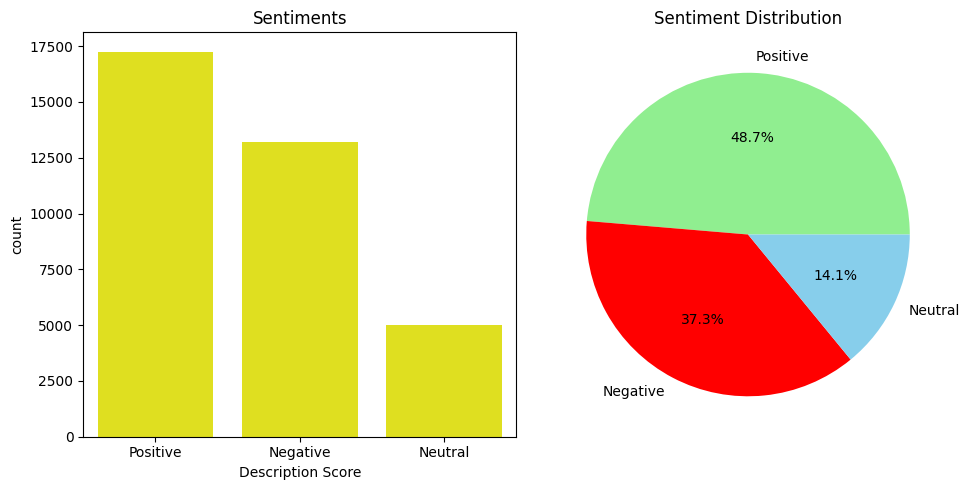

In [67]:
score_counts = df_description['Description Score'].value_counts()

plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.countplot(x='Description Score', data=df_description, color = 'yellow')
plt.title('Sentiments')

colors = ['lightgreen',  'red', 'skyblue']
plt.subplot(122)
plt.pie(score_counts, labels=score_counts.index, colors=colors, autopct='%1.1f%%')
plt.title('Sentiment Distribution')

plt.tight_layout();

* *Upon analyzing the descriptions from the aforementioned chart, it is evident that there are **17,500 positive sentiments**, accounting for **48.7%** of the total.* 
* *Additionally, there are **12,600 negative sentiments**, representing **37.3%** of the total.*
* *Furthermore, there are **500 neutral sentiments**, making up **14.1%** of the overall sentiment distribution.* 

#### *Modeling on the Descriptions*

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df_description['Description'], 
                                                    df_description['Description Score'], 
                                                    test_size = 0.1, 
                                                    random_state = 222 )

##### *LINEAR SUPPORT VECTOR MACHINE*

In [69]:
%%time
pipeline = Pipeline([
    ('Tfidf Vectorizer', TfidfVectorizer()),
    ('ML Model', LinearSVC())])

model_LinearSVC111 = pipeline.fit(X_train, y_train)
predictions = model_LinearSVC111.predict(X_test)

print('ML Model - Linear SVC\n')

accuracy_LinearSVC111 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_LinearSVC111 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))

ML Model - Linear SVC

Accuracy Score: 85.96%

Confusion Matrix
[[1162   36  145]
 [  54  316  111]
 [ 106   46 1571]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.88      0.87      0.87      1343
     Neutral       0.79      0.66      0.72       481
    Positive       0.86      0.91      0.89      1723

    accuracy                           0.86      3547
   macro avg       0.84      0.81      0.83      3547
weighted avg       0.86      0.86      0.86      3547

CPU times: user 2.04 s, sys: 14.9 ms, total: 2.06 s
Wall time: 2.08 s


##### *LOGISTIC REGRESSION*

In [70]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', LogisticRegression())])

model_LogR111 = pipeline.fit(X_train, y_train)
predictions = model_LogR111.predict(X_test)

accuracy_LogR111 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_LogR111 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))

Accuracy Score: 81.76%

Confusion Matrix
[[1115   27  201]
 [  78  214  189]
 [ 120   32 1571]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.85      0.83      0.84      1343
     Neutral       0.78      0.44      0.57       481
    Positive       0.80      0.91      0.85      1723

    accuracy                           0.82      3547
   macro avg       0.81      0.73      0.75      3547
weighted avg       0.82      0.82      0.81      3547

CPU times: user 7.03 s, sys: 6.18 s, total: 13.2 s
Wall time: 8.25 s


##### *MULTINOMIAL NAIVE BAYES*

In [71]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', MultinomialNB())])

model_MNB111 = pipeline.fit(X_train, y_train)
predictions = model_MNB111.predict(X_test)

accuracy_MNB111 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_MNB111 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))


Accuracy Score: 67.55%

Confusion Matrix
[[ 775    1  567]
 [  54   18  409]
 [ 119    1 1603]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.82      0.58      0.68      1343
     Neutral       0.90      0.04      0.07       481
    Positive       0.62      0.93      0.75      1723

    accuracy                           0.68      3547
   macro avg       0.78      0.51      0.50      3547
weighted avg       0.73      0.68      0.63      3547

CPU times: user 1.12 s, sys: 12.4 ms, total: 1.14 s
Wall time: 1.15 s


##### *BERNOULLI NAIVE BAYES*

In [72]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', BernoulliNB())
])

model_BNB111 = pipeline.fit(X_train, y_train)
predictions = model_BNB111.predict(X_test)

accuracy_BNB111 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_BNB111 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))


Accuracy Score: 71.64%

Confusion Matrix
[[ 975   27  341]
 [  92  152  237]
 [ 263   46 1414]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.73      0.73      0.73      1343
     Neutral       0.68      0.32      0.43       481
    Positive       0.71      0.82      0.76      1723

    accuracy                           0.72      3547
   macro avg       0.71      0.62      0.64      3547
weighted avg       0.71      0.72      0.70      3547

CPU times: user 1.15 s, sys: 8.49 ms, total: 1.16 s
Wall time: 1.17 s


##### *CATBOOST CLASSIFIER*

In [73]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', CatBoostClassifier(iterations=10, random_state=33, verbose=False))
])

model_CB111 = pipeline.fit(X_train, y_train)
predictions = model_CB111.predict(X_test)
print('ML Model - CatBoost\n')

accuracy_CB111 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_CB111 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))

ML Model - CatBoost

Accuracy Score: 62.22%

Confusion Matrix
[[ 599    3  741]
 [   5   24  452]
 [ 134    5 1584]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.81      0.45      0.58      1343
     Neutral       0.75      0.05      0.09       481
    Positive       0.57      0.92      0.70      1723

    accuracy                           0.62      3547
   macro avg       0.71      0.47      0.46      3547
weighted avg       0.69      0.62      0.57      3547

CPU times: user 35.1 s, sys: 1.17 s, total: 36.2 s
Wall time: 22.2 s


In [74]:
models = [model_LinearSVC111,
          model_LogR111, 
          model_MNB111,
          model_BNB111,
          model_CB111]

names = ['LinearSVC', 
         'Logistic Regression', 
         'Multinomial Naive Bayes',
         'Bernoulli\'s Naive Bayes',
         'CatBoost']

model_comparision(models, names, X_train, y_train, X_test, y_test)

LinearSVC
Classification Report 
               precision    recall  f1-score   support

    Negative       0.88      0.87      0.87      1343
     Neutral       0.79      0.66      0.72       481
    Positive       0.86      0.91      0.89      1723

    accuracy                           0.86      3547
   macro avg       0.84      0.81      0.83      3547
weighted avg       0.86      0.86      0.86      3547

Logistic Regression
Classification Report 
               precision    recall  f1-score   support

    Negative       0.85      0.83      0.84      1343
     Neutral       0.78      0.44      0.57       481
    Positive       0.80      0.91      0.85      1723

    accuracy                           0.82      3547
   macro avg       0.81      0.73      0.75      3547
weighted avg       0.82      0.82      0.81      3547

Multinomial Naive Bayes
Classification Report 
               precision    recall  f1-score   support

    Negative       0.82      0.58      0.68      1343
   

> *After analyzing the descriptions from the three newspapers, it is evident that the ***Linear SVC*** algorithm outperformed other algorithms in accurately predicting sentiments with an accuracy score of ***85.9%***, it demonstrated its superior performance in accurately classifying the sentiments conveyed in the descriptions.*

#### *Predicting*

In [75]:
sent1 = ['GST officers detect Rs 4,000 crore of ITC fraud in April-June']
y_predict = model_LinearSVC1.predict(sent1)
y_predict

array(['Negative'], dtype=object)

In [76]:
sent2 = ["Finance Ministry releases Rs 9,871 crore to 17 states as grant"]
y_predict = model_LinearSVC1.predict(sent2)
y_predict

array(['Positive'], dtype=object)

***`Project Conclusion:`*** 
> *Sentiment Analysis of Newspaper Headlines and Descriptions*

* *In this project, I conducted sentiment analysis on three different data frames containing time, headlines, and descriptions from various newspapers (CNBC, the Guardian, and Reuters Headlines) . The project workflow involved loading the data, handling duplicates and missing values, and performing **sentiment analysis using the VADER** (Valence Aware Dictionary and sEentiment Reasoner) lexicon from the NLTK library.*

* *I started by merging the description and headline columns into a single text column and predicted the sentiments of the combined dataset. Utilizing algorithms such as **Linear SVC, Logistic Regression, Naive Bayes (Multinomial and Bernoulli), and CatBoost**, I aimed to accurately classify the sentiments as positive, negative, or neutral. After evaluating the performance of these algorithms, Linear SVC stood out with an impressive accuracy of almost 90%.*

* *Furthermore, I proceeded to analyze the sentiments individually based on the headlines and descriptions separately. This approach allowed me to gain insights into the sentiment composition of each aspect*

* *Overall, The project's findings highlight the significance of considering both the headlines and descriptions when predicting sentiments in financial news. This comprehensive approach using machine learning algorithms can aid in extracting valuable insights from textual data and assist in decision-making processes.*
